In [1]:
import csv
import numpy as np
import math
from operator import sub
import operator
import matplotlib.pyplot as plt

### Loading data

In [2]:
csv_path = "card.csv"
with open(csv_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    headers = next(reader)
    data = list(reader)
    data = np.array(data).astype(float)
data = data[:200]
N = len(data)
l = len(data[0]) - 1
classCount = 10

### Data normalization

In [77]:
#NORMALIZATION

maxs = [e for e in data[0]]
mins = [e for e in data[0]]
for row in data:
    for i in range(0, l):
        if row[i] > maxs[i]:
            maxs[i] = row[i]
        if row[i] < mins[i]:
            mins[i] = row[i]

normData = np.zeros((N, l + 1))

for i in range(0, N):
    for j in range(0, l):
        normData[i][j] = (data[i][j] - mins[j]) / (maxs[j] - mins[j]) if (maxs[j] - mins[j]) != 0 else 0
    normData[i][l] = data[i][l]

### Usefull functions

In [78]:
#DISTANCE
def euclidean(x, y):
    res = 0.0
    for a, b in zip(x, y):
        res = res + (a - b) ** 2
    return math.sqrt(res)
 
    
def chebyshev(x, y):
    return abs(max(map(sub, x, y), key=abs))


def manhattan(x, y):
        return sum(map(abs, map(sub, x, y)))
    
distance_dict = {
    "euclidean" : euclidean,
    "chebyshev" : chebyshev,
    "manhattan" : manhattan
}

#KERNEL
def uniform(x):
    if abs(x) >= 1:
        return 0
    else:
        return 0.5
 
 
def triangular(x):
    if abs(x) >= 1:
        return 0
    else:
        return 1 - abs(x)
 
 
def epanechnikov(x):
    if abs(x) >= 1:
        return 0
    else:
        return 0.75 * (1 - x ** 2)
 
 
def quartic(x):
    if abs(x) >= 1:
        return 0
    else:
        return 15 / 16 * (1 - x ** 2) ** 2
 
 
def triweight(x):
    if abs(x) >= 1:
        return 0
    else:
        return 35 / 32 * (1 - x ** 2) ** 3
 
 
def tricube(x):
    if abs(x) >= 1:
        return 0
    else:
        return 70 / 81 * (1 - abs(x) ** 3) ** 3
 
 
def gaussian(x):
    return 1 / math.sqrt(math.pi * 2) * math.exp((-0.5) * x ** 2)
 
def cosine(x):
    if abs(x) >= 1:
        return 0
    else:
        return math.pi / 4 * math.cos(math.pi / 2 * x)
 
 
def logistic(x):
    return 1 / (math.e ** x + 2 + math.e ** (-x))

def sigmoid(x):
    return 2 / math.pi / (math.e ** x + math.e ** (-x))

kernel_dict = {
    "uniform" : uniform,
    "triangular" : triangular,
    "epanechnikov" : epanechnikov,
    "quartic" : quartic,
    "triweight" : triweight,
    "tricube" : tricube,
    "gaussian" : gaussian,
    "cosine" : cosine,
    "logistic" : logistic,
    "sigmoid" : sigmoid
}

#WINDOW
def fixed(h, points, kernel):
    return list(map(lambda x: kernel(x / h), points))
 
def variable(k, points, kernel):
    h = points[k]
    return list(map(lambda x: kernel(x / h), points))


### HIERARCHICAL CLUSTERING

In [295]:
import copy

# R(W,S)=αU⋅R(U,S)+αV⋅R(V,S)+β⋅R(U,V)+γ⋅|R(U,S)−R(V,S)|
def dist(r, u, v, s):
    au = 0.5
    av = 0.5
    gum = 0.5
    
    return au * r[u][s] + av * r[v][s] + gum * abs(r[u][s] - r[v][s])


def find_new_cluster(distances):
    x_min = copy.deepcopy(next(iter(distances)))
    y_min = copy.deepcopy(next(iter(distances[x_min])))
    min_dist = distances[x_min][y_min]
    
    for x in distances:
        for y in distances[x]:
            if x != y and distances[x][y] < min_dist:
                min_dist = distances[x][y]
                x_min = x
                y_min = y
                            
    return x_min, y_min


def hier_step(distances, orig_distances):
    u, v = find_new_cluster(distances)
    new_cluster = set(u)
    new_cluster.update(v)
    new_cluster = frozenset(new_cluster)
    new_distances = {new_cluster : {}}

    for x in distances:
        if not x.issubset(new_cluster):
            new_distances[x] = {}
            for y in distances:
                if x != y and not y.issubset(new_cluster):
                    new_distances[x][y] = distances[x][y]
            
            new_distances[new_cluster][x] = dist(distances, u, v, x)
            new_distances[x][new_cluster] = dist(distances, u, v, x)
                
    return new_distances

def hier(orig_distances, clusters_num):
    distances = copy.deepcopy(orig_distances)
    
    it = 0
    while len(distances) > clusters_num:
        #print("hier clustering, step", it)
        it += 1
        distances = hier_step(distances, orig_distances)
        #print("KEYS:", distances.keys())
    return distances.keys()

In [296]:
def ds_to_distances(ds):
    distances = {}
    for i in range(len(ds)):
        distances[frozenset([i])] = {}
    for i in range(len(ds)):
        i_set = frozenset([i])
        for j in range(i + 1, len(ds)):
            j_set = frozenset([j])
            cur_dist = chebyshev(ds[i], ds[j])
            distances[i_set][j_set] = cur_dist
            distances[j_set][i_set] = cur_dist
            
    return distances

In [297]:
def get_new_labels(y, pred_y):
    d = {}
    for i in range(len(y)):
        if y[i] not in d:
            d[y[i]] = {}
        if pred_y[i] not in d[y[i]]:
            d[y[i]][pred_y[i]] = 1
        else:
            d[y[i]][pred_y[i]] += 1
    d_res = {}
    print(d)
    for k in d:
        max_label = -1
        max_count = -1
        for k2 in d[k]:
            if d[k][k2] > max_count:
                max_count = d[k][k2]
                max_label = k2
        d_res[k] = max_label
    return d_res
            

In [298]:
def get_confusion_table(y, pred_y):
    c = len(set(y))
    ct = [[0 for j in range(c)] for i in range(c)]
    for y1, p in zip(y, pred_y):
        ct[p][y1] += 1
    return ct

In [299]:
print(get_confusion_table([0, 1, 2], [1, 1, 2]))

[[0, 0, 0], [1, 1, 0], [0, 0, 1]]


In [300]:
def calcFMeasure(v):
    n = len(v)
    summ = sum([sum(row) for row in v])
    precision_macro = 0
    recall_macro = 0
  
    for i in range(n):
        x = 0
        y = 0
        for j in range(n):
            x += v[i][j]
            y += v[j][i]
      
        precision = v[i][i] / x if x != 0 else 0
        recall = v[i][i] / y if y != 0 else 0
        precision_macro += precision * x
        recall_macro += recall * x
  
    return 2.0 * precision_macro * recall_macro / (precision_macro + recall_macro) / summ if precision_macro + recall_macro != 0 and sum != 0 else 0

In [301]:
print(calcFMeasure(get_confusion_table([0, 1, 2], [1, 1, 2])))

0.7999999999999999


In [302]:
print(ds_to_distances([[1,1], [0, 0]]))

{frozenset({0}): {frozenset({1}): 1}, frozenset({1}): {frozenset({0}): 1}}


In [303]:
print(normData.shape)

(200, 36)


In [304]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

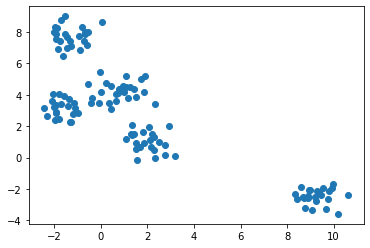

In [305]:
X, y = make_blobs(n_samples=120, centers=5, cluster_std=0.60, random_state=0)
plt.scatter(X[:,0], X[:,1])

In [306]:
clusters = hier(ds_to_distances(X), 5)

In [307]:
it = 0
point_to_cluster = {}
for cluster in clusters:
    for point in cluster:
        point_to_cluster[point] = it
    it += 1
pred_y = [point_to_cluster[i] for i in range(len(X))]

In [308]:
new_labels = get_new_labels(pred_y, y)
y_trans = [new_labels[e] for e in pred_y]

{4: {2: 21}, 3: {1: 24}, 0: {0: 24, 2: 3}, 1: {3: 24}, 2: {4: 24}}


In [309]:
print(new_labels)

{4: 2, 3: 1, 0: 0, 1: 3, 2: 4}


In [310]:
ct = get_confusion_table(y, y_trans)

In [311]:
for row in ct:
    print(row)

[24, 0, 3, 0, 0]
[0, 24, 0, 0, 0]
[0, 0, 21, 0, 0]
[0, 0, 0, 24, 0]
[0, 0, 0, 0, 24]


In [312]:
F = calcFMeasure(ct)
print("F measure:", F)

F measure: 0.97656


In [313]:
def get_cluster_cohesion(x, clusters):
    res = 0
    for cluster in clusters:
        mean = sum([np.array(x[point]) for point in cluster]) / len(cluster)
        for point in cluster:
            res += np.linalg.norm(x[point] - mean) ** 2
    return res

In [314]:
CC = get_cluster_cohesion(X, clusters)
print('Cluster Cohesion:', CC)

Cluster Cohesion: 80.89873207215827


In [316]:
def get_rand_index(y, p):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(y)):
        for j in range(i + 1, len(y)):
            if y[i] == y[j]:
                if p[i] == p[j]:
                    tp += 1
                else:
                    fp += 1
            else:
                if p[i] == p[j]:
                    tn += 1
                else:
                    fn += 1
    return (tp + fn) / (tp + fp + tn + fn)

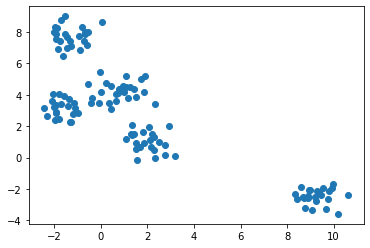

{0: {2: 24, 1: 24, 0: 24}, 1: {3: 24}, 2: {4: 24}}


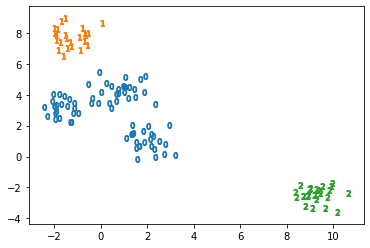

[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[24, 24, 24, 0, 0]
[0, 0, 0, 24, 0]
[0, 0, 0, 0, 24]
Random Index: 0.7579831932773109
Cluster Cohesion: 371.2124044062063


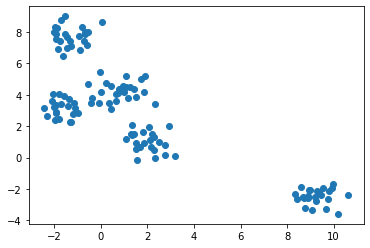

{4: {2: 21}, 3: {1: 24}, 0: {0: 24, 2: 3}, 1: {3: 24}, 2: {4: 24}}


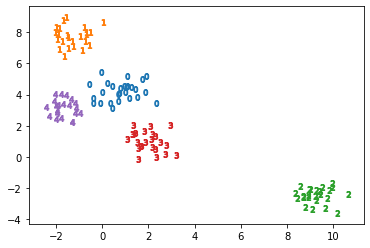

[24, 0, 3, 0, 0]
[0, 24, 0, 0, 0]
[0, 0, 21, 0, 0]
[0, 0, 0, 24, 0]
[0, 0, 0, 0, 24]
Random Index: 0.9810924369747899
Cluster Cohesion: 80.89873207215827


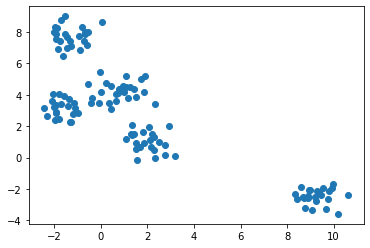

{4: {2: 21}, 2: {1: 24}, 5: {0: 16}, 3: {3: 15}, 1: {4: 24}, 6: {3: 9}, 0: {2: 3, 0: 8}}


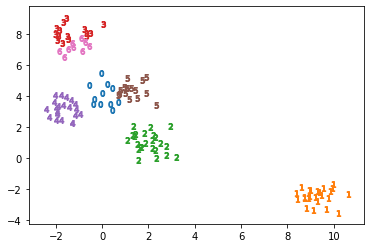

[24, 0, 3, 0, 0]
[0, 24, 0, 0, 0]
[0, 0, 21, 0, 0]
[0, 0, 0, 24, 0]
[0, 0, 0, 0, 24]
Random Index: 0.9509803921568627
Cluster Cohesion: 65.08037028117208


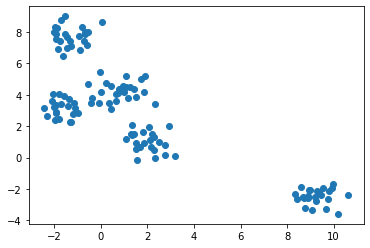

{2: {2: 21}, 0: {1: 24}, 3: {0: 16}, 1: {3: 15}, 4: {4: 21}, 6: {3: 9}, 8: {2: 3, 0: 3}, 5: {0: 5}, 7: {4: 3}}


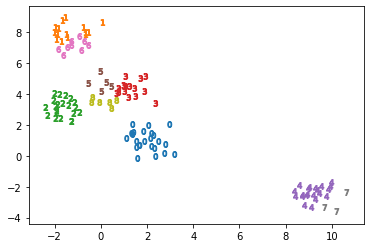

[21, 0, 0, 0, 0]
[0, 24, 0, 0, 0]
[3, 0, 24, 0, 0]
[0, 0, 0, 24, 0]
[0, 0, 0, 0, 24]
Random Index: 0.942156862745098
Cluster Cohesion: 56.8419944370314


In [317]:
ccs = []
ris = []
X, y = make_blobs(n_samples=120, centers=5, cluster_std=0.60, random_state=0)
for k in [3, 5, 7, 9]:
    
    plt.scatter(X[:,0], X[:,1])
    
    plt.show()
    clusters = hier(ds_to_distances(X), k)
    it = 0
    point_to_cluster = {}
    for cluster in clusters:
        for point in cluster:
            point_to_cluster[point] = it
        it += 1
    pred_y = [point_to_cluster[i] for i in range(len(X))]
    
    new_labels = get_new_labels(pred_y, y)
    y_trans = [new_labels[e] for e in pred_y]
    for i in range(k):
        indeces = [j for j in range(len(X)) if pred_y[j] == i]
        plt.scatter([X[j][0] for j in indeces], [X[j][1] for j in indeces], marker='$' + str(i) + '$')
    plt.show()
    ct = get_confusion_table(y, y_trans)
    for row in ct:
        print(row)
    ri = get_rand_index(y, pred_y)
    print('Random Index:', ri)
    ris.append(ri)
    
    CC = get_cluster_cohesion(X, clusters)
    print('Cluster Cohesion:', CC)
    ccs.append(CC)

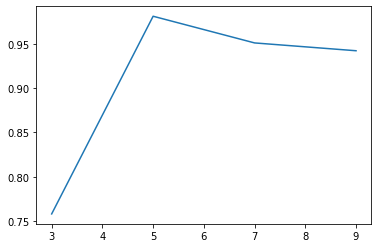

In [318]:
plt.plot([3, 5, 7, 9], ris)

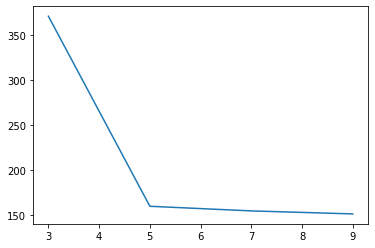

In [287]:
plt.plot([3, 5, 7, 9], ccs)

In [274]:
def y_to_clusters(y):
    d = {}
    for i in range(len(y)):
        if y[i] not in d:
            d[y[i]] = set([i])
        else:
            d[y[i]].add(i)
    return d.values()

In [275]:
print(y_to_clusters(y_trans))

dict_values([{0, 3, 4, 5, 15, 18, 20, 22, 26, 29, 30, 31, 32, 37, 39, 40, 42, 43, 45, 47, 48, 50, 51, 53, 54, 55, 58, 60, 61, 65, 67, 71, 75, 76, 78, 80, 82, 83, 84, 86, 95, 99, 102, 109, 110, 113, 116}, {1, 2, 8, 17, 24, 28, 33, 34, 35, 36, 41, 46, 57, 59, 72, 77, 81, 85, 87, 89, 94, 97, 98, 106}, {6, 7, 9, 11, 12, 13, 63, 66, 68, 70, 73, 74, 79, 88, 91, 92, 93, 100, 105, 111, 112, 114, 118, 119}, {10, 14, 16, 19, 21, 23, 25, 27, 38, 44, 49, 52, 56, 62, 64, 69, 90, 96, 101, 104, 107, 108, 115, 117}, {103}])


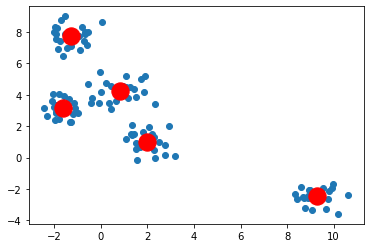

In [258]:
import pandas as pd
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
base_y = kmeans.fit_predict(X)
plt.scatter(X[:,0], X[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

In [276]:
clusters_base = y_to_clusters(base_y)

In [277]:
CC_base = get_cluster_cohesion(X, clusters_base)
print('Cluster Cohesion:', CC_base)

Cluster Cohesion: 80.44851679621783


In [221]:
labels_dict = get_new_labels(y, pred_y)

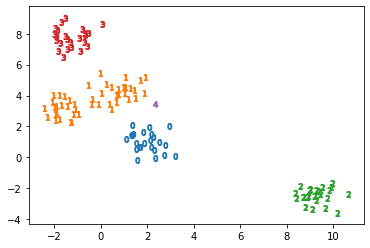

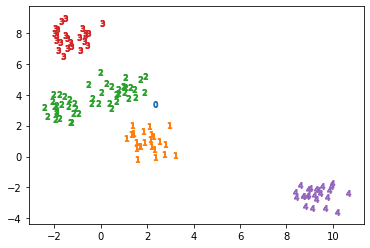

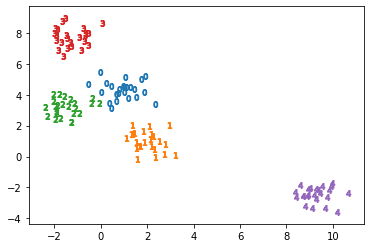

In [228]:
clusters = list(clusters)
for i in range(5):
    indeces = [j for j in range(len(X)) if pred_y[j] == i]
    plt.scatter([X[j][0] for j in indeces], [X[j][1] for j in indeces], marker='$' + str(i) + '$')
plt.show()

for i in range(5):
    indeces = [j for j in range(len(X)) if y_trans[j] == i]
    plt.scatter([X[j][0] for j in indeces], [X[j][1] for j in indeces], marker='$' + str(i) + '$')
plt.show()

for i in range(5):
    indeces = [j for j in range(len(X)) if y[j] == i]
    plt.scatter([X[j][0] for j in indeces], [X[j][1] for j in indeces], marker='$' + str(i) + '$')
    

In [172]:
y_trans = get_new_labels(y, pred_y)

{1: 2, 2: 1}

In [239]:
sum([np.array([1, 2]), np.array([1, 1])]) / 2

array([1. , 1.5])